In [1]:
import torch
print(torch.__version__)
print(torch.backends.mps.is_available())  # Should return True on M1/M2/M3

import torchvision
print(torchvision.__version__)

2.7.1
True
0.22.1


In [2]:
import coremltools
print(coremltools.__version__)

Torch version 2.7.1 has not been tested with coremltools. You may run into unexpected errors. Torch 2.5.0 is the most recent version that has been tested.


8.3.0


In [3]:
from torchvision import transforms

# mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_dataset = ImageFolder('../Datasets/relabeled/train', transform=train_transform)
val_dataset = ImageFolder('../Datasets/relabeled/test', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

Number of training samples: 6612
Number of test samples: 1656


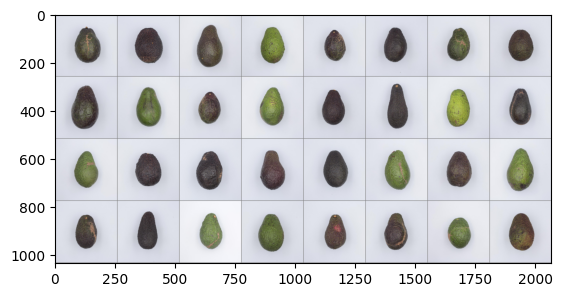

Labels: tensor([1, 2, 1, 0, 2, 2, 1, 1, 1, 0, 1, 0, 2, 2, 0, 1, 0, 2, 2, 1, 1, 0, 2, 0,
        1, 2, 0, 0, 1, 0, 0, 1])


In [5]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(val_dataset)}")

# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(make_grid(images))
print('Labels:', labels)

In [6]:
import torch.nn as nn
import timm

num_classes = len(train_dataset.classes)  # Your dataset’s class count

model = timm.create_model('fastvit_sa12', pretrained=True, num_classes=num_classes)  # Load without classifier head
# model.head = nn.Linear(768, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)

/opt/homebrew/Caskroom/miniconda/base/envs/fastvit/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss = running_loss / len(val_loader)
    val_acc = 100 * correct / total
    return val_loss, val_acc

# Training loop
num_epochs = 10
best_val_loss = float("-inf")
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    scheduler.step()

    if val_loss > best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'fastvit_finetuned.pth')

Epoch 1/10, Train Loss: 0.9180, Train Acc: 61.06%, Val Loss: 0.7738, Val Acc: 68.84%
Epoch 2/10, Train Loss: 0.7182, Train Acc: 72.84%, Val Loss: 0.6665, Val Acc: 74.52%
Epoch 3/10, Train Loss: 0.6353, Train Acc: 75.12%, Val Loss: 0.6135, Val Acc: 76.93%
Epoch 4/10, Train Loss: 0.5987, Train Acc: 76.44%, Val Loss: 0.5656, Val Acc: 77.84%
Epoch 5/10, Train Loss: 0.5741, Train Acc: 76.95%, Val Loss: 0.5655, Val Acc: 76.51%
Epoch 6/10, Train Loss: 0.5623, Train Acc: 77.09%, Val Loss: 0.5489, Val Acc: 78.14%
Epoch 7/10, Train Loss: 0.5522, Train Acc: 77.48%, Val Loss: 0.5315, Val Acc: 78.99%
Epoch 8/10, Train Loss: 0.5449, Train Acc: 78.04%, Val Loss: 0.5274, Val Acc: 79.77%
Epoch 9/10, Train Loss: 0.5400, Train Acc: 78.55%, Val Loss: 0.5420, Val Acc: 78.02%
Epoch 10/10, Train Loss: 0.5429, Train Acc: 77.60%, Val Loss: 0.5445, Val Acc: 77.90%


In [10]:
val_loss, val_acc = validate(model, val_loader, criterion, device)
print(f"Final Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

Final Validation Loss: 0.5445, Accuracy: 77.90%


In [14]:
torch.save(model.state_dict(), 'fastvit_finetuned.pth')

In [13]:
import coremltools as ct

model.eval()
example_input = torch.rand(1, 3, 256, 256).to(device)
traced_model = torch.jit.trace(model, example_input)
coreml_model = ct.convert(
    traced_model,
    inputs=[ct.ImageType(name="input", shape=example_input.shape)],
    classifier_config=ct.ClassifierConfig(train_dataset.classes)
)
coreml_model.save("FastViT_Finetuned.mlpackage")

When both 'convert_to' and 'minimum_deployment_target' not specified, 'convert_to' is set to "mlprogram" and 'minimum_deployment_target' is set to ct.target.iOS15 (which is same as ct.target.macOS12). Note: the model will not run on systems older than iOS15/macOS12/watchOS8/tvOS15. In order to make your model run on older system, please set the 'minimum_deployment_target' to iOS14/iOS13. Details please see the link: https://apple.github.io/coremltools/docs-guides/source/target-conversion-formats.html
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 208.45 passes/s]
